In [1]:
import requests
import csv
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import Quandl
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import RandomizedPCA 

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor 
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.grid_search import GridSearchCV

---

In [2]:
def get_stock_data(ticker, seconds_interval, num_of_days):
    
    url = "http://www.google.com/finance/getprices?q={0}&i={1}&p={2}d&f=d,o,h,l,c,v".format(ticker, seconds_interval, num_of_days)

    # get data and convert to data frame
    stock_df = pd.read_csv(url, skiprows=[0,1,2,3,5,6])

    # rename column name
    stock_df.rename(columns={'COLUMNS=DATE':'time'}, inplace=True)

    # remove 'a' from unix timestamps
    stock_df.replace(to_replace={'time':{'a':''}}, regex=True, inplace=True)

    # get entire column and convert to ints
    time_indices = [int(x) for x in stock_df['time'].values]

    # keep track of current timestamp
    last_timestamp = time_indices[0]

    # convert unix timestamp abbreviations into full unix timestamps
    for i in range(len(time_indices)):
        if time_indices[i] < last_timestamp:
            time_indices[i] = last_timestamp + (time_indices[i] * seconds_interval)
        else:
            last_timestamp = time_indices[i]

    # convert unix timestamps to human-readable formats
    time_indices = [datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in time_indices]
    
    # keep times (i.e., not dates)
    times = [float(x[-8:-3].replace(':','.')) for x in time_indices]

    # create new column in data frame
    stock_df['time'] = times

    # keep day of month
    #dates = [int(x[:10].split('-')[2]) for x in time_indices]
    # create new column in data frame
    #stock_df['month_date'] = dates

    # get weekday as int value
    #stock_df['week_day'] = [datetime.datetime.strptime(x[:10], '%Y-%m-%d').weekday() for x in time_indices]

    # create features
    stock_df['op_cl%'] = np.true_divide((stock_df['CLOSE'] - stock_df['OPEN']), stock_df['CLOSE'])
    stock_df['lo_hi%'] = np.true_divide((stock_df['HIGH'] - stock_df['LOW']), stock_df['HIGH'])
    stock_df['vol_norm'] = np.true_divide(stock_df['VOLUME'], np.max(stock_df['VOLUME']))

    # create labels dataframe
    labels_df = stock_df.copy(deep=True)

    # remove columns
    stock_df = stock_df.drop(['CLOSE', 'OPEN', 'LOW', 'HIGH', 'VOLUME'], axis=1)

    #print stock_df.shape
    #stock_df.head()
    
    return stock_df, labels_df

In [3]:
tickers = ['ARNA',
           'ATNM',
           'AVXL',
           'AXN',
           'BLFS',
           'BOTA',
           'CBLI',
           'CPRX', 
           'DARA',
           'ECYT',
           'EDAP',
           'EXAS',
           'HALO',
           'IDRA',
           'INO',
           'LOXO',
           'LPCN',
           'MEIP',
           'MNKD',
           'OREX',
           'PGNX',
           'QLTI',
           'RMTI',
           'SGYP',
           'SNGX',
           'SPY',
           'SYN', 
           'TENX',
           'THLD',
           'TNXP',
           'TPIV']

---

In [4]:
# download data

for ticker in tickers:
    
    seconds_interval = 1800 # 1800: 30-minute (seems the most consistent)
    stock_df, labels_df = get_stock_data(ticker, seconds_interval, 1000)
        
    stock_df.to_csv("goog_data/{}_features.csv".format(ticker), index=False)
    labels_df.to_csv("goog_data/{}_labels.csv".format(ticker), index=False)

---

In [419]:
# import data

X = []
y = []

for ticker in tickers:

    stock_df = pd.read_csv("goog_data/{}_features.csv".format(ticker))
    labels_df = pd.read_csv("goog_data/{}_labels.csv".format(ticker))

    num_of_times = stock_df['time'].unique().shape[0]
    stock_df = stock_df.drop('time', axis=1)
    assert num_of_times == 14, "wrong number of times"
    #print "number of times in a day: {}".format(num_of_times)

    num_of_days = stock_df.shape[0]/num_of_times
    #print "number of days: {}".format(num_of_days)

    for i in xrange(num_of_days):

        # features
        features = stock_df.values[:num_of_times].flatten()
        features = np.expand_dims(features, axis=0)
        #assert features.shape[1] == 84, "wrong number of columns"

        # combine features into rows of X
        if X == []:
            X = features
        else: 
            X = np.vstack((X, features))

        # labels
        labels = labels_df.values[:num_of_times].flatten()
        # (last - open) / last
        label = np.true_divide((labels[-8] - labels[1]), labels[-8])

        if y == []:
            y = np.array([label])
        else:
            y = np.append(y, np.array(label))  

        # remove used rows (go to next day)
        stock_df = stock_df[num_of_times:]
        labels_df = labels_df[num_of_times:]

    # rotate/discard rows
    X = X[:-1]
    y = y[1:]

print "\n", "*"*10, "\nfinal shapes: ", X.shape, y.shape


********** 
final shapes:  (875, 42) (875,)


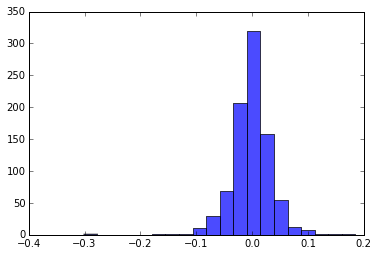

In [420]:
plt.hist(y, bins=20, alpha=0.7)
plt.show()

In [421]:
corr_df = pd.DataFrame(X)
corr_df['label'] = y
np.max(corr_df.corr()['label'].values[:-1])

0.059615438143112785

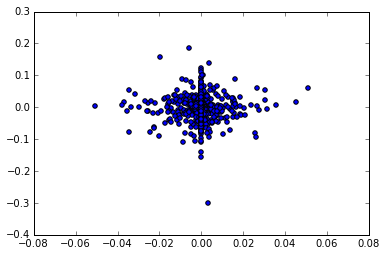

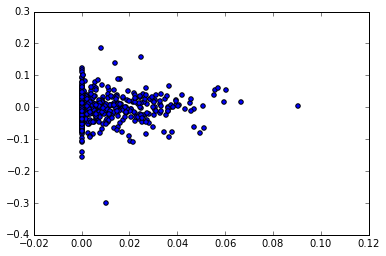

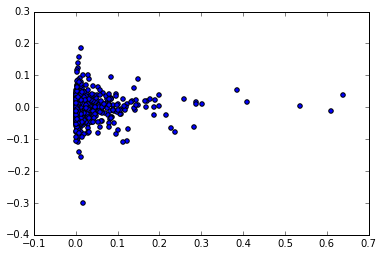

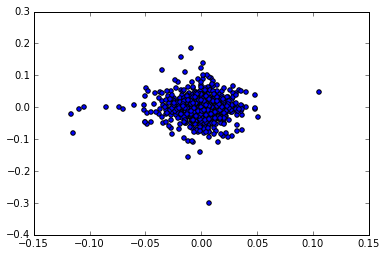

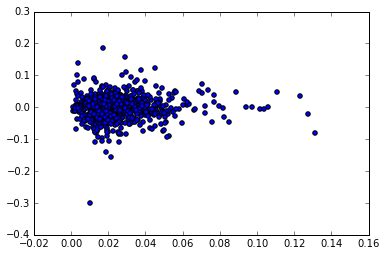

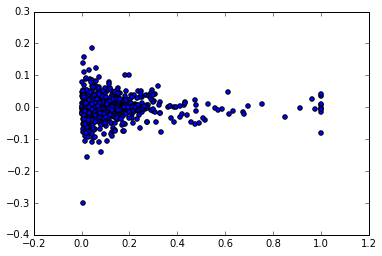

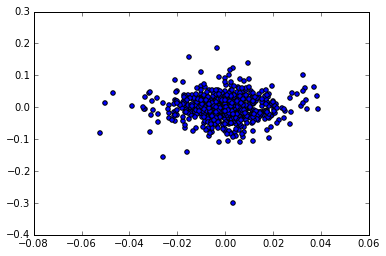

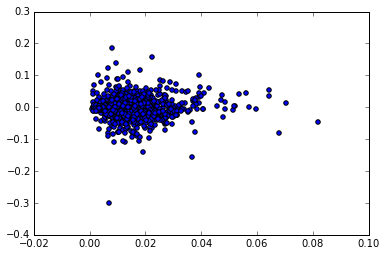

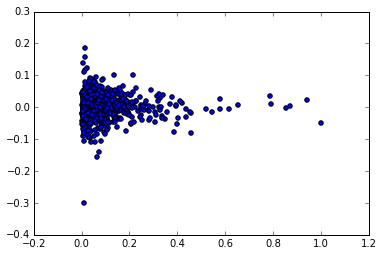

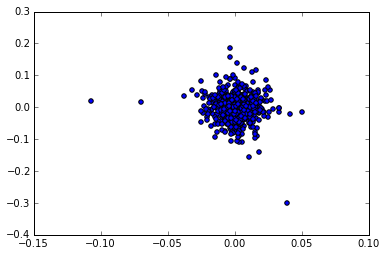

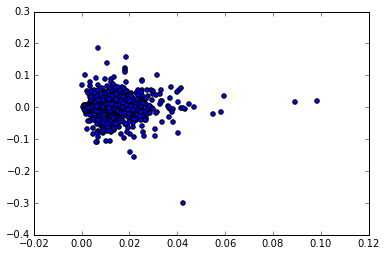

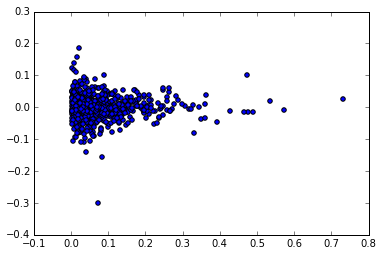

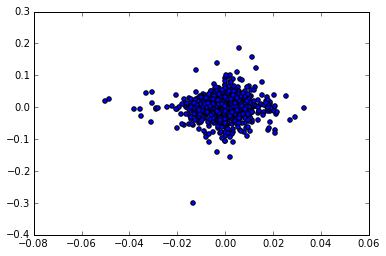

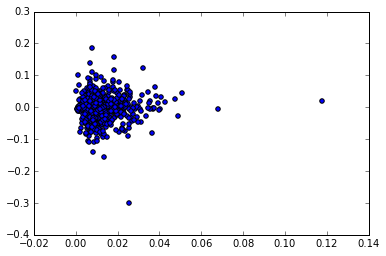

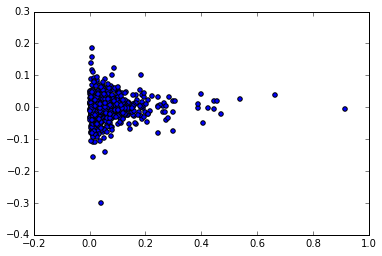

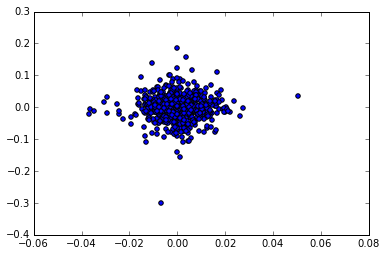

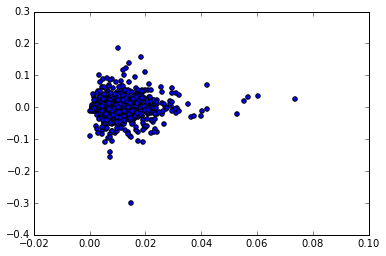

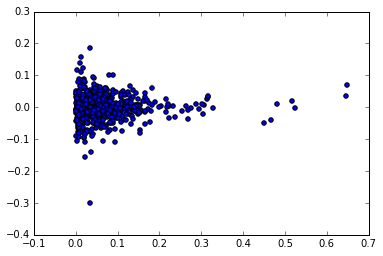

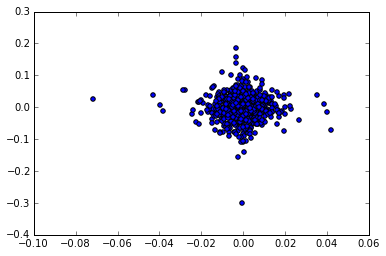

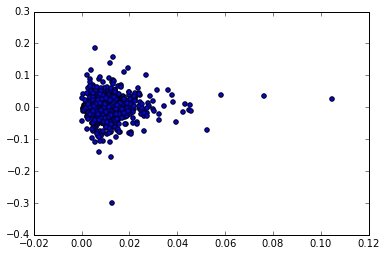

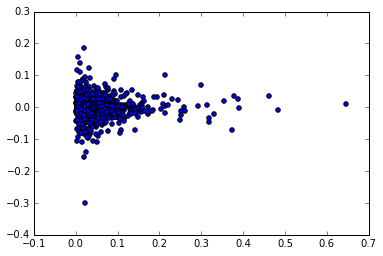

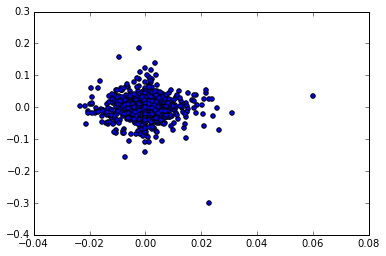

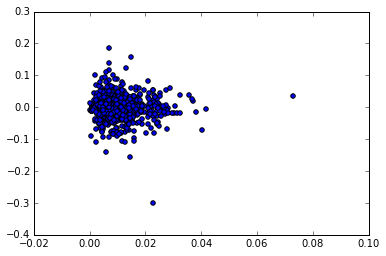

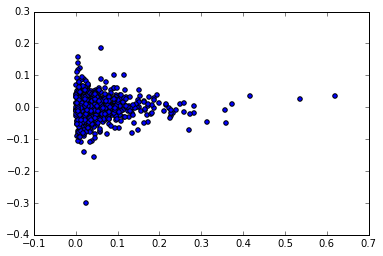

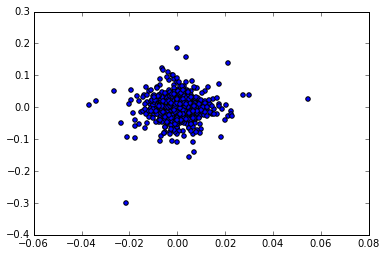

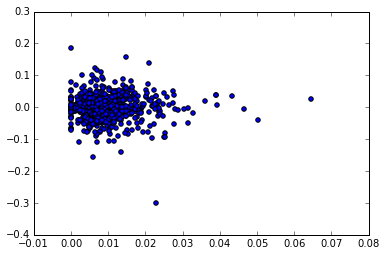

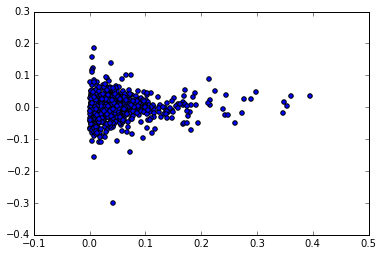

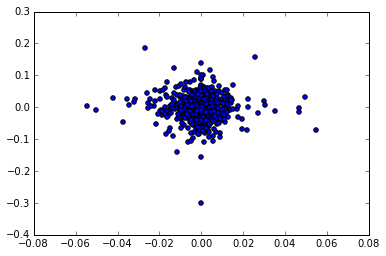

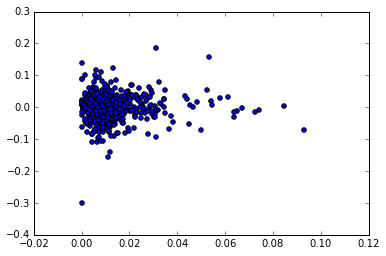

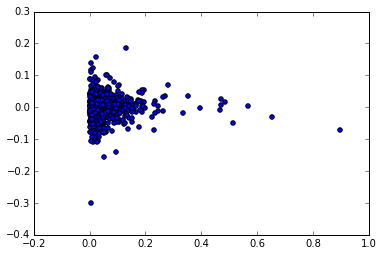

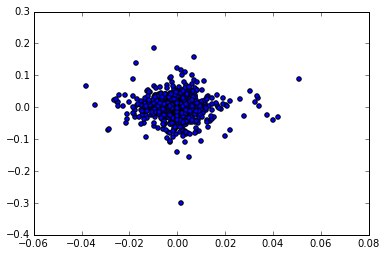

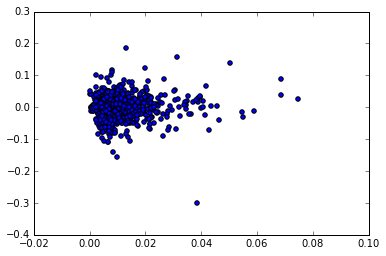

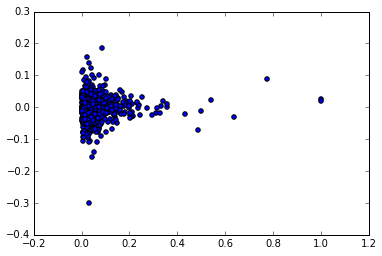

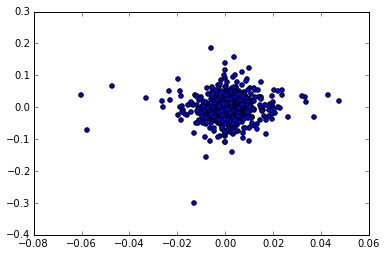

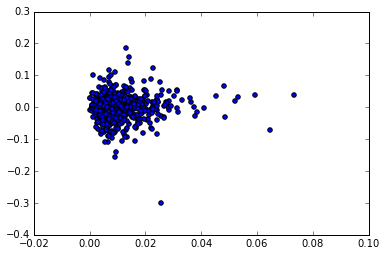

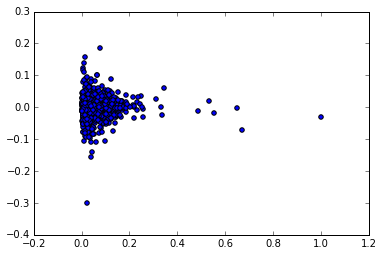

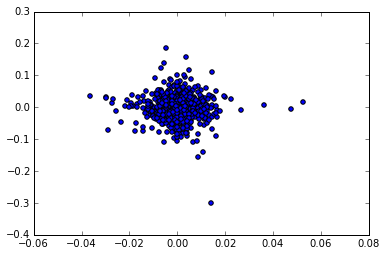

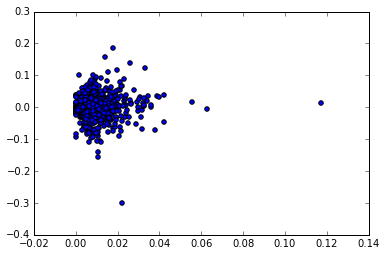

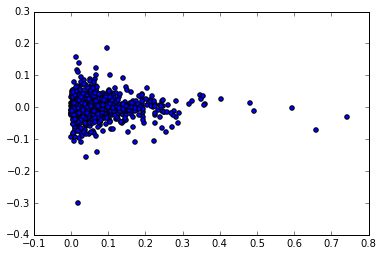

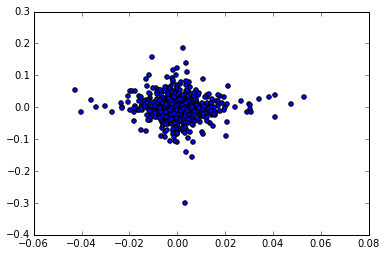

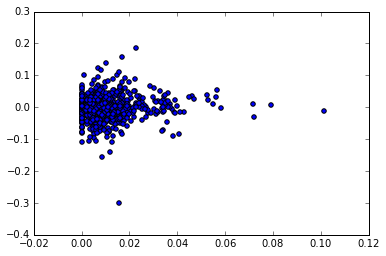

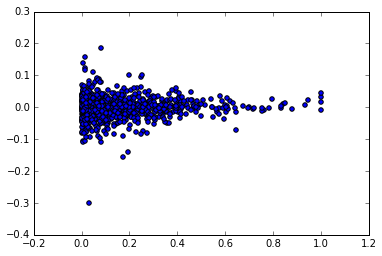

In [422]:
for i in xrange(X.shape[1]):
    plt.scatter(X[:,i], y)
    plt.show()

---

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [409]:
#skb = SelectKBest(k=4)
#skb.fit(X_train,y_train)
#X_train = skb.transform(X_train)
#X_test = skb.transform(X_test)

In [410]:
#for i in xrange(X_train.shape[1]):
#    plt.scatter(X_train[:,i], y_train)
#    plt.show()

In [411]:
#scaler = MinMaxScaler()
#scaler.fit(X_train,y_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [412]:
#pca = RandomizedPCA(n_components=4)
#pca.fit(X_train,y_train)
#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

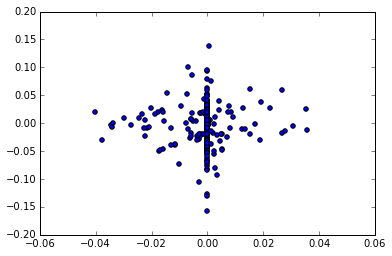

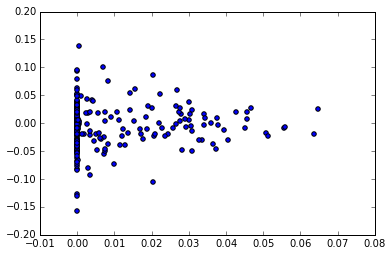

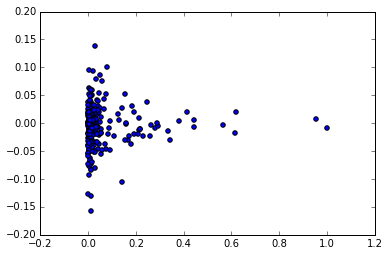

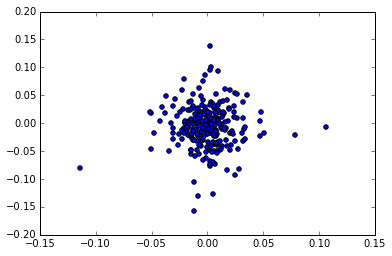

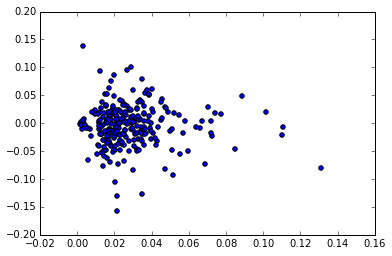

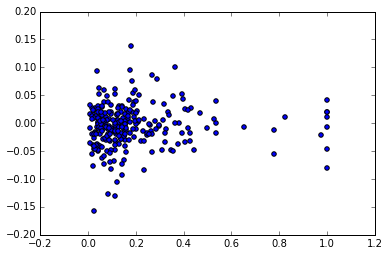

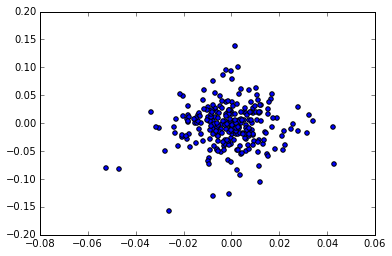

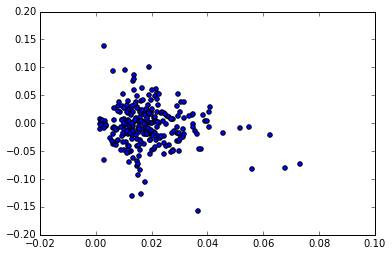

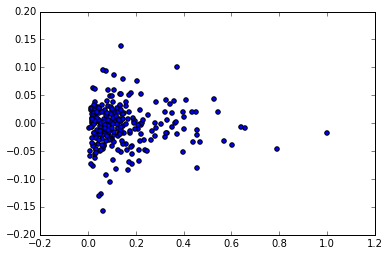

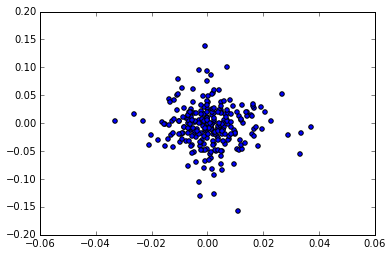

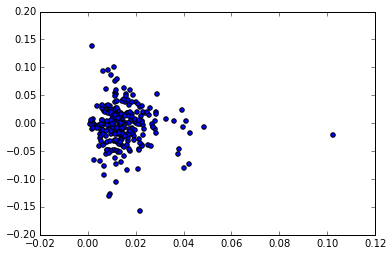

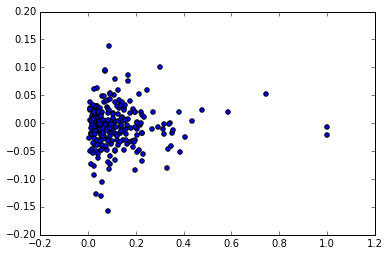

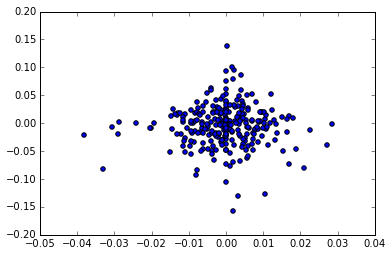

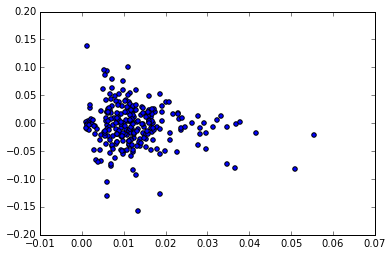

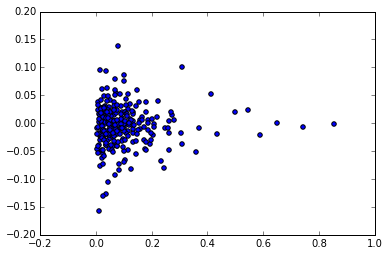

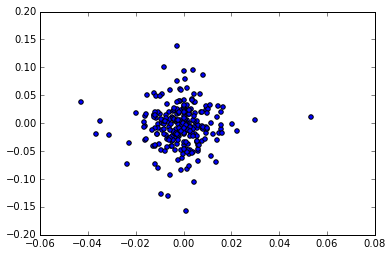

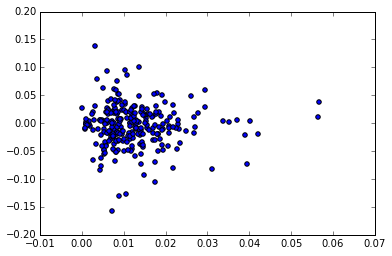

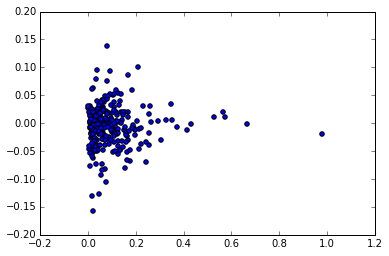

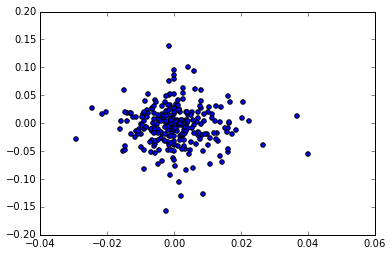

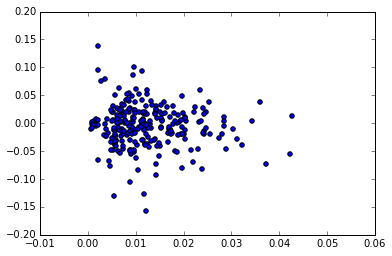

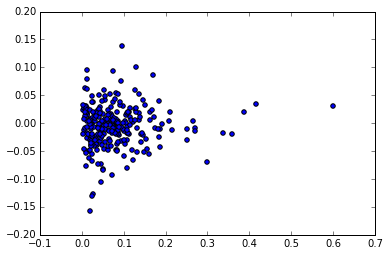

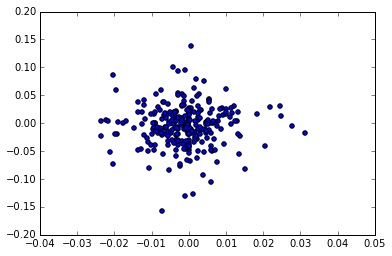

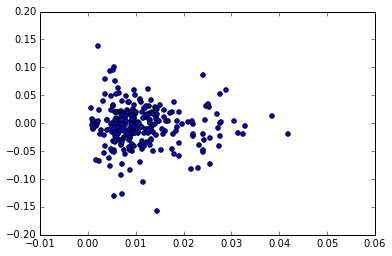

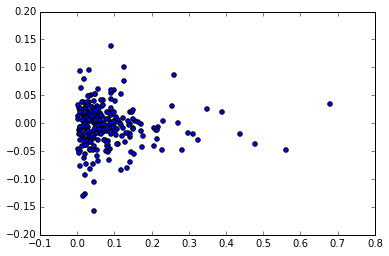

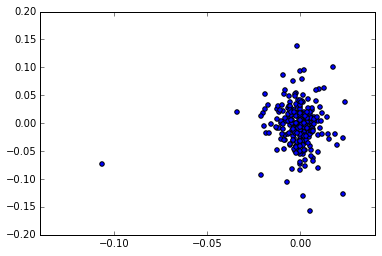

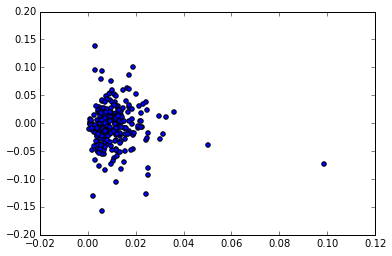

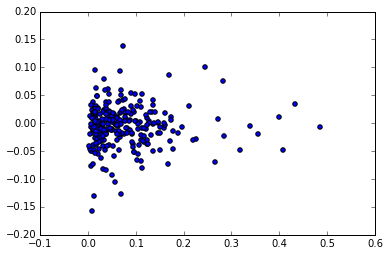

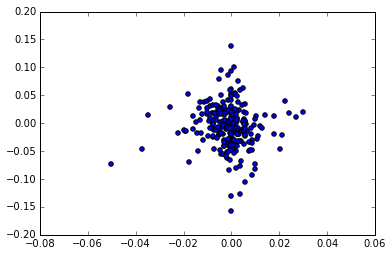

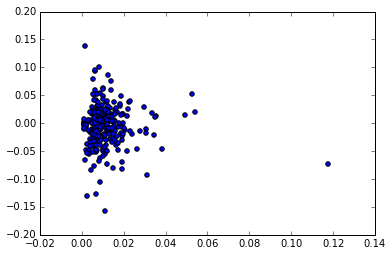

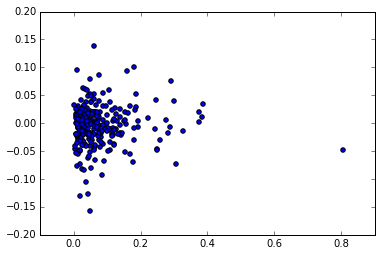

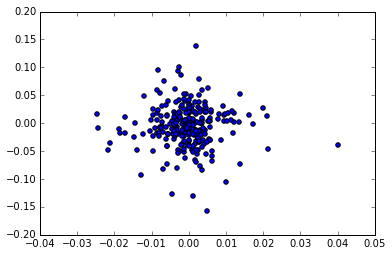

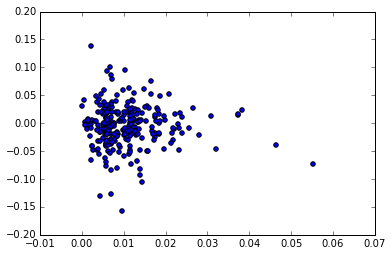

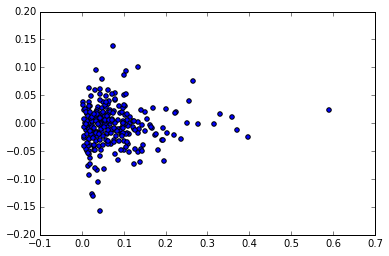

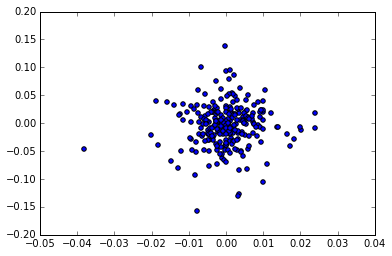

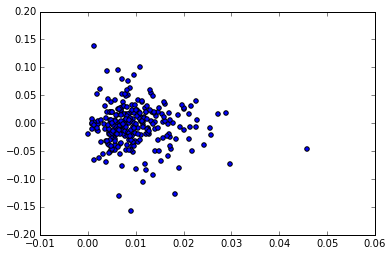

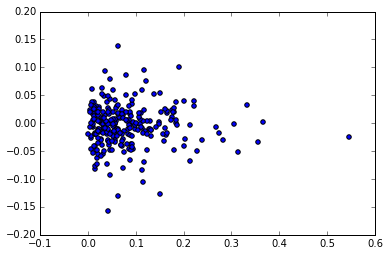

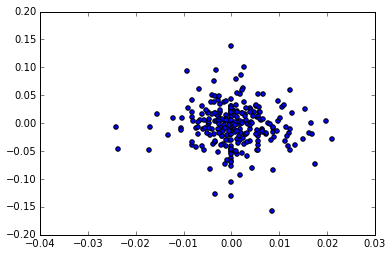

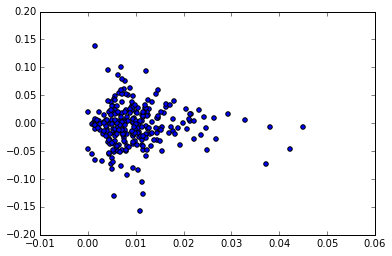

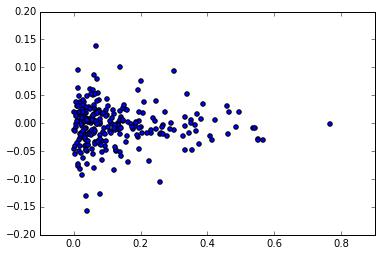

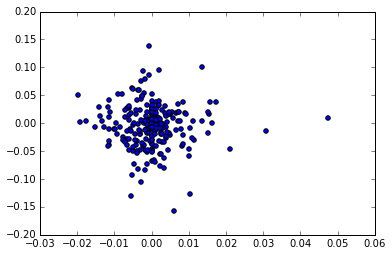

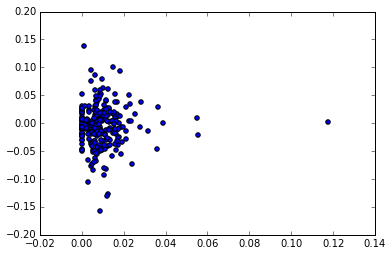

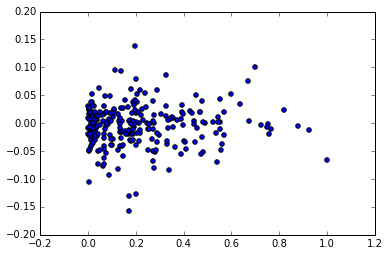

In [413]:
for i in xrange(X_train.shape[1]):
    plt.scatter(X_train[:,i], y_train)
    plt.show()

In [414]:
num_rows = X_train.shape[0]
num_cols = X_train.shape[1]
rows_to_remove = set()

for i in xrange(num_cols):
    low = np.percentile(X_train[:,i], 5)
    high = np.percentile(X_train[:,i], 95)
    
    for j in xrange(num_rows):
        if X_train[j,i] == low or X_train[j,i] == high:
            rows_to_remove.add(j)

X_train = np.delete(X_train, list(rows_to_remove), axis=0)
y_train = np.delete(y_train, list(rows_to_remove))

print "\nnew X_train shape: ", X_train.shape


new X_train shape:  (72, 42)


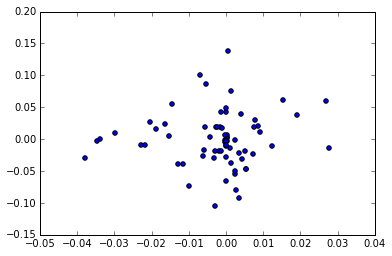

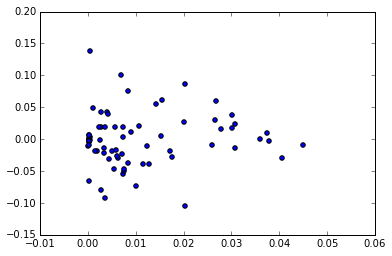

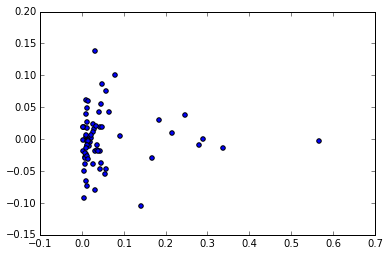

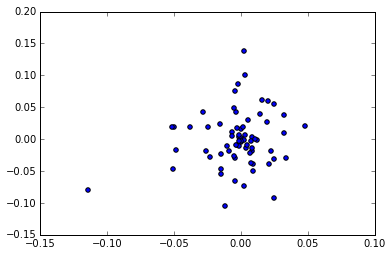

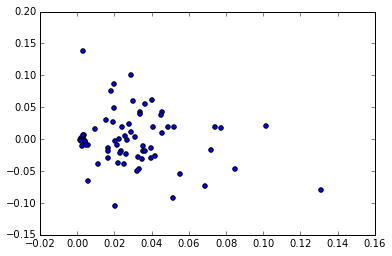

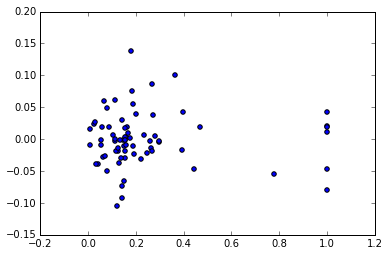

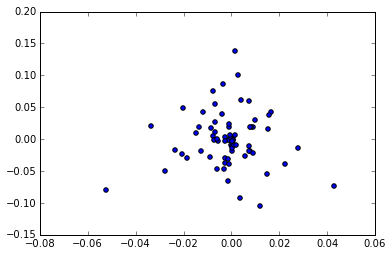

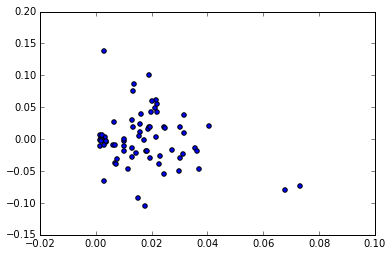

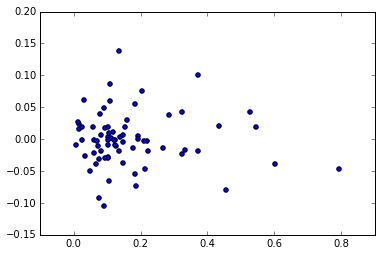

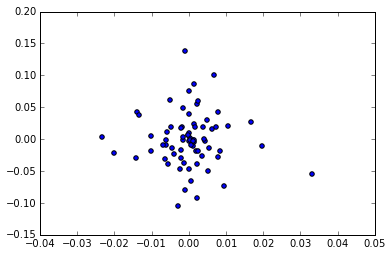

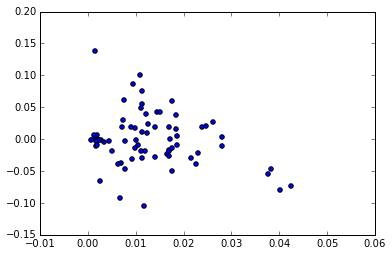

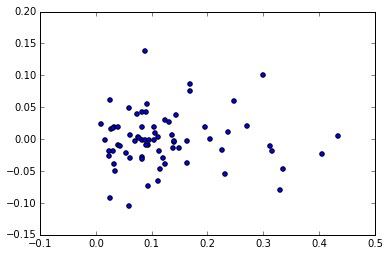

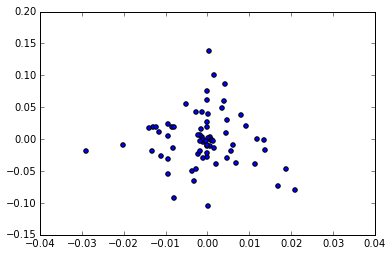

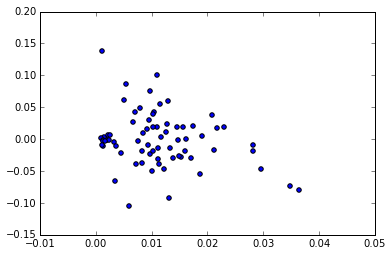

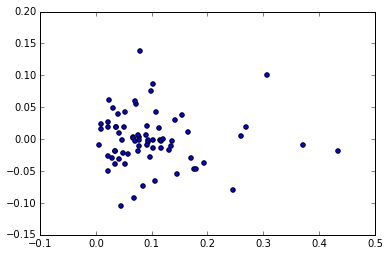

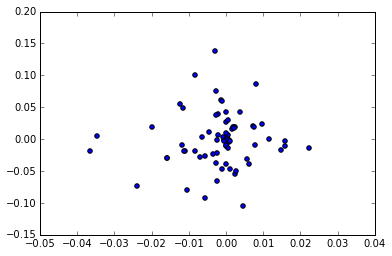

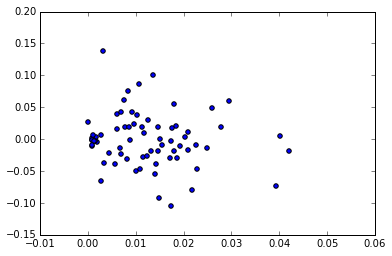

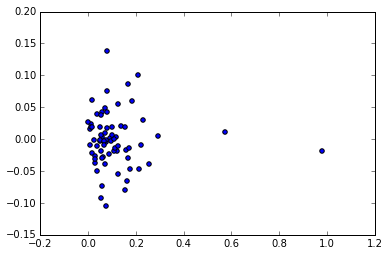

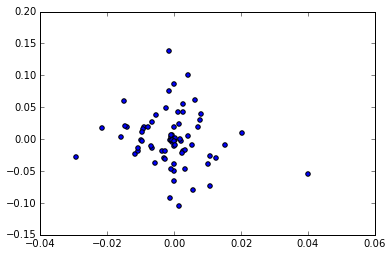

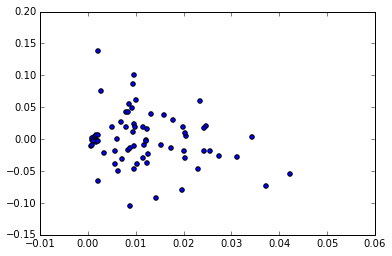

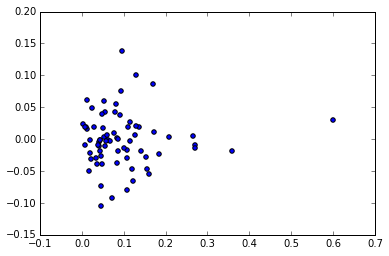

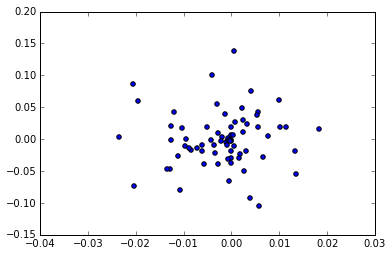

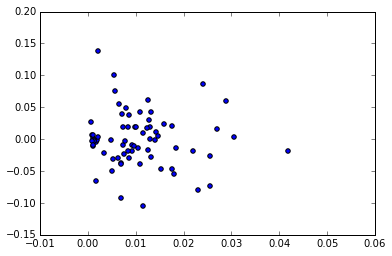

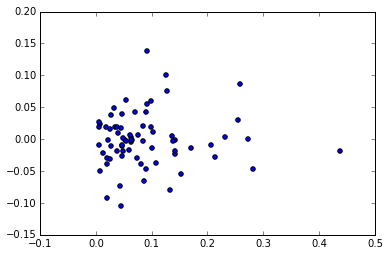

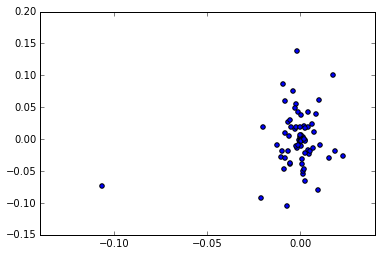

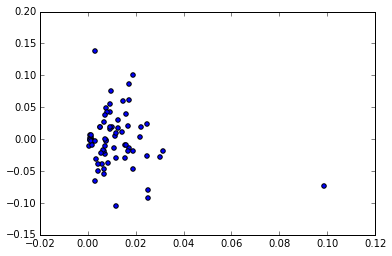

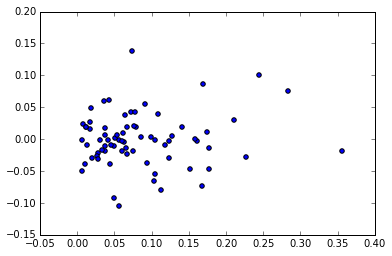

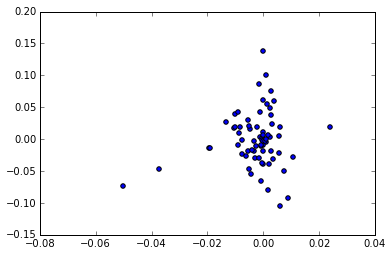

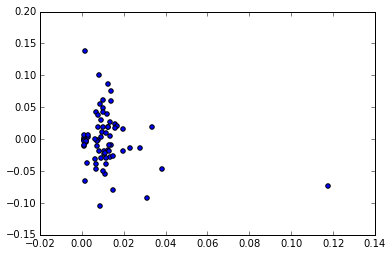

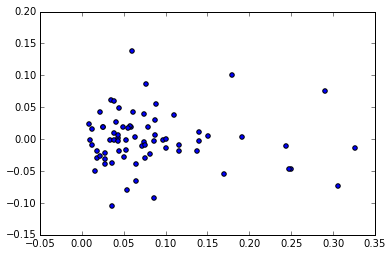

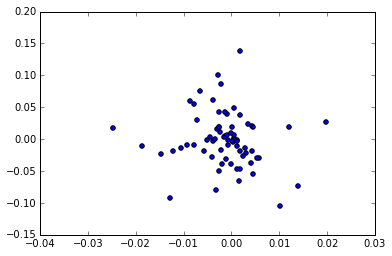

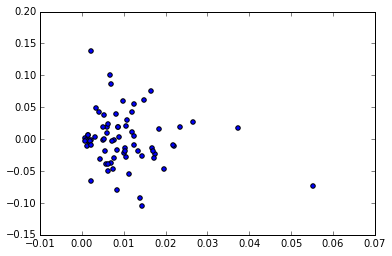

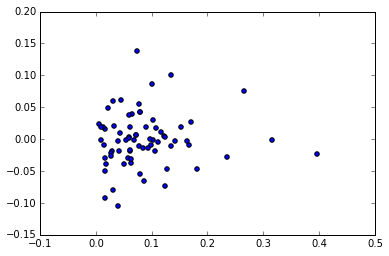

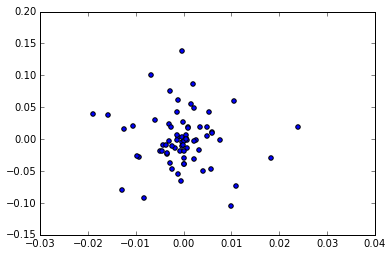

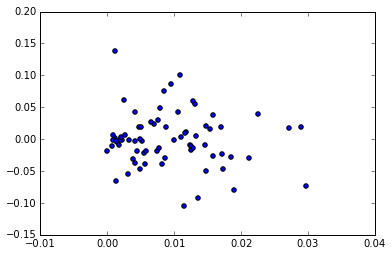

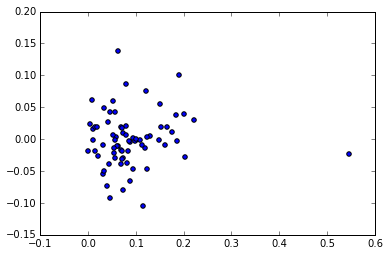

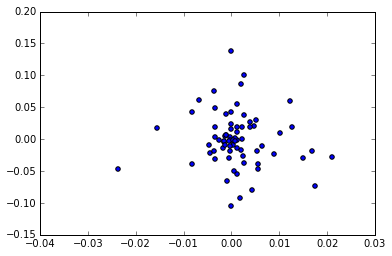

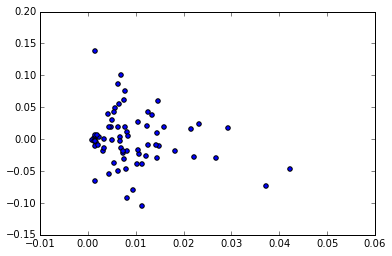

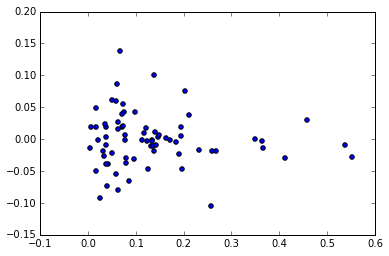

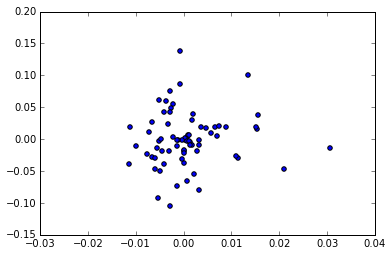

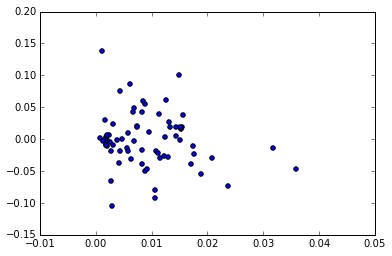

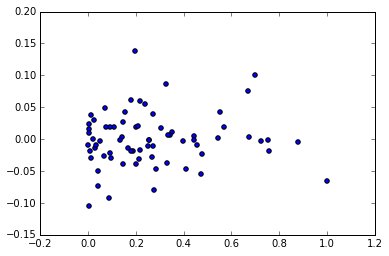

In [415]:
for i in xrange(X_train.shape[1]):
    plt.scatter(X_train[:,i], y_train)
    plt.show()

In [423]:
#poly = PolynomialFeatures(degree=3)
#poly.fit(X_train,y_train)
#X_train = poly.transform(X_train)
#X_test = poly.transform(X_test)

high_score = -9999999

y_pred = []

for regr in [LinearRegression(), Ridge(), Lasso(), BayesianRidge(), SGDRegressor(), SVR(), DecisionTreeRegressor(), GradientBoostingRegressor()]:
    regr = regr.fit(X_train, y_train)
    score = regr.score(X_test, y_test)
    print score
    if score > high_score:
        high_score = score
        y_pred = regr.predict(X_test)

-3.5202274539
-0.0116092944819
-0.00507507178557
-0.00513186397227
-0.00538191216529
-0.0328318480632
-1.01467388565
-0.57369045293


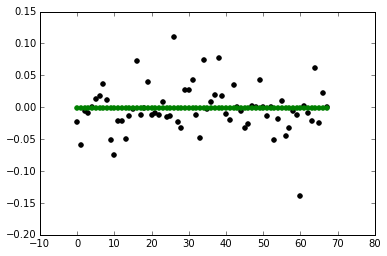

In [424]:
plt.scatter(np.arange(y_test.shape[0]), y_test, color='k')
plt.scatter(np.arange(y_pred.shape[0]), y_pred, color='g')
plt.show()